In [16]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

In [17]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import imgaug as ia
import random

from pathlib import Path
from numpy import asarray
from imgaug import augmenters as iaa
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize

In [18]:
train_data_path = '../../sensix_daninhas/dataset/train'
validation_data_path  = '../../sensix_daninhas/dataset/validation'

img_rows = 100
img_cols = 100
epochs = 100
batch_size = 20
n_channels = 3

In [19]:
num_of_train_samples = sum(len(files) for _, _, files in os.walk(train_data_path))
num_of_validation_samples  = sum(len(files) for _, _, files in os.walk(validation_data_path))
print("Train Images : ", num_of_train_samples)
print("Validation Images  : ", num_of_validation_samples)

Train Images :  4149
Validation Images  :  962


In [20]:
def random_func(*, percentage: int) -> int:
    '''
    percentage: Valores entre 0 e 100. Caso percentage > _value é retornado true, caso não
    é retornado false
    
    description: Utilizada para definir se a função de pré processamento será utilizada ou
    não. 
    
    return:
    bool
    '''
    _value = random.randint(0, 100)
    if _value < percentage:
        #print(_value)
        return False
    else:
        #print(_value)
        return True

In [21]:
def prepare_dataset_func_1(img):
    '''
    img: array que representa a imagem que será modificada:
    
    description: Representa efeitos relacionados a coloração da imagem. Nenhuma
    rotação ou aproximação (zoom) é dado. Apenas possui filtros que alteram as 
    caracteristicas gerais das imagens
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    if random_func(percentage = 10):
        seq = iaa.Sequential([
            #iaa.Affine(rotate=(0, 90)),
            #iaa.Crop(percent=(0.1, 0.2)),
            iaa.LinearContrast((1.0, 1.9)),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.AdditiveGaussianNoise(scale=(10, 20)),
            #iaa.Crop(percent=(0, 0.2)),
            iaa.AddToBrightness((-30, 30)),
            iaa.AddToHue((-50, 50)),
            #iaa.flip.Fliplr(0.5)
            #iaa.AllChannelsHistogramEqualization()
        ],
        random_order=True)
        images_aug = seq(image=img)
    else:
        images_aug = img
    
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [22]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

In [23]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   preprocessing_function=prepare_dataset_func_1,
                                   fill_mode='constant',
                                   #shear_range=45,
                                   #channel_shift_range=100,
                                   #horizontal_flip=True,
                                   #vertical_flip=True
                                   )

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  )


train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    )

validation_generator = test_datagen.flow_from_directory(validation_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        )

Found 4149 images belonging to 2 classes.
Found 962 images belonging to 2 classes.


In [24]:
reset_random_seeds()

visible = tf.keras.layers.Input(shape=(img_rows, img_cols, n_channels))
conv1 = tf.keras.layers.Conv2D(8, (3,3), activation='relu')(visible)
pooling1 = tf.keras.layers.MaxPooling2D(2, 2)(conv1)
conv2 = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(pooling1)
pooling2 = tf.keras.layers.MaxPooling2D(2,2)(conv2)
conv3 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(pooling2)
pooling3 = tf.keras.layers.MaxPooling2D(2,2)(conv3)
conv4 = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(pooling3)
pooling4 = tf.keras.layers.MaxPooling2D(2,2)(conv4)
flat = tf.keras.layers.Flatten()(pooling3)
hidden1 = tf.keras.layers.Dense(64, activation='relu')(flat)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hidden1)

model = tf.keras.Model(inputs=visible, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 32)        0   

In [25]:
class CallbackStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        _percent = 0.95
        tf.keras.callbacks.TensorBoard(log_dir='logs')
        if logs.get('val_accuracy') is not None and logs.get('accuracy') and logs.get('val_accuracy') > _percent and logs.get('accuracy') > _percent:
            print("\nO treino foi cancelado, obtido mais de",_percent," de accuracy!", "\n")
            self.model.stop_training = True
            

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=10, min_delta=0.001, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

callbacks = CallbackStop()

history = model.fit(train_generator,
                    steps_per_epoch= num_of_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_of_validation_samples // batch_size,
                    callbacks=[callbacks]
                    )

Epoch 1/100
207/207 [==============================] - 21s 99ms/step - loss: 0.6381 - accuracy: 0.6526 - val_loss: 0.5529 - val_accuracy: 0.7615
Epoch 2/100
207/207 [==============================] - 22s 107ms/step - loss: 0.5692 - accuracy: 0.7240 - val_loss: 0.5993 - val_accuracy: 0.6625
Epoch 3/100
207/207 [==============================] - 22s 106ms/step - loss: 0.5631 - accuracy: 0.7157 - val_loss: 0.5354 - val_accuracy: 0.7448
Epoch 4/100
207/207 [==============================] - 22s 106ms/step - loss: 0.5554 - accuracy: 0.7179 - val_loss: 0.5421 - val_accuracy: 0.7323
Epoch 5/100
207/207 [==============================] - 23s 109ms/step - loss: 0.5258 - accuracy: 0.7325 - val_loss: 0.6274 - val_accuracy: 0.6542
Epoch 6/100
207/207 [==============================] - 20s 97ms/step - loss: 0.5335 - accuracy: 0.7392 - val_loss: 0.4989 - val_accuracy: 0.7521
Epoch 7/100
207/207 [==============================] - 19s 91ms/step - loss: 0.5198 - accuracy: 0.7614 - val_loss: 0.5055 - va

207/207 [==============================] - 19s 90ms/step - loss: 0.1529 - accuracy: 0.9480 - val_loss: 0.1757 - val_accuracy: 0.9365
Epoch 58/100
207/207 [==============================] - 19s 92ms/step - loss: 0.1582 - accuracy: 0.9462 - val_loss: 0.1802 - val_accuracy: 0.9521
Epoch 59/100
207/207 [==============================] - 21s 101ms/step - loss: 0.1670 - accuracy: 0.9475 - val_loss: 0.1547 - val_accuracy: 0.9635
Epoch 60/100
207/207 [==============================] - 20s 95ms/step - loss: 0.1759 - accuracy: 0.9466 - val_loss: 0.1834 - val_accuracy: 0.9438
Epoch 61/100
207/207 [==============================] - 19s 92ms/step - loss: 0.1728 - accuracy: 0.9465 - val_loss: 0.1874 - val_accuracy: 0.9667

O treino foi cancelado, obtido mais de 0.95  de accuracy! 



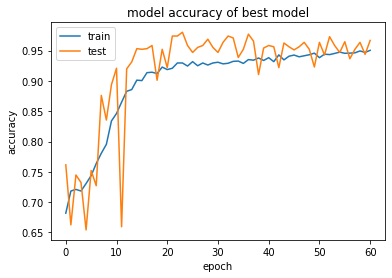

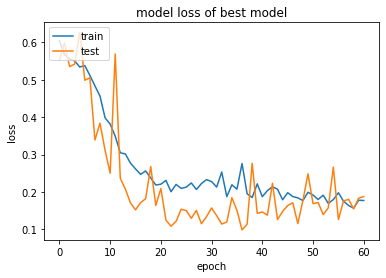

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of best model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of best model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
image_path = '../../sensix_daninhas/ortomosaicos/pos-emergente/test2/nao'
#image_path = '../../sensix_daninhas/dataset/test/'
#image_path = '../../sensix_daninhas/gabarito_sim/'


images = []

for img in os.listdir(image_path):
        img = os.path.join(image_path, img)
        img = image.load_img(img, target_size=(100,100))
        img = image.img_to_array(img)
        #print(img)
        img = np.expand_dims(img, axis=0)
        processed_image = np.array(img, dtype="float")
        images.append(processed_image)
        
images = np.vstack(images)
print(len(images))

22


count_daninha 4
count_sem_daninha 18


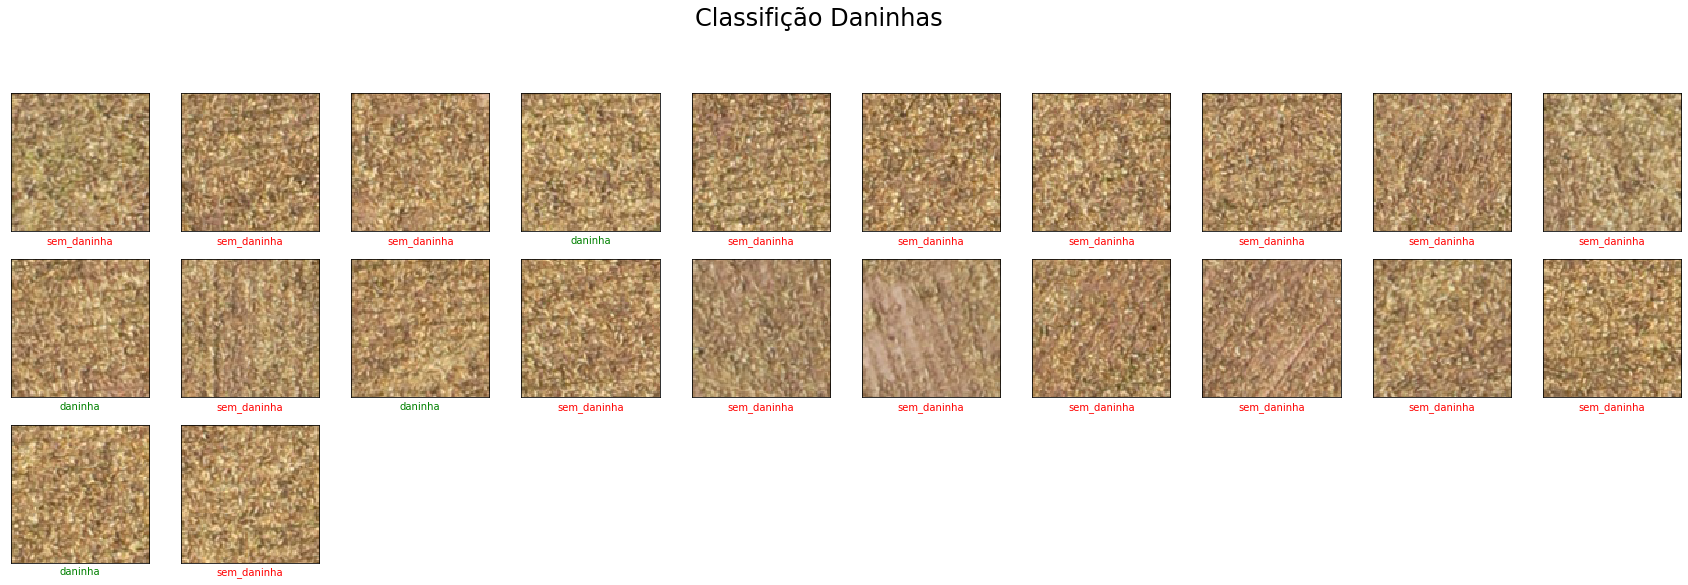

In [36]:
images_data = []
filenames = []
count_daninha = 0
count_sem_daninha = 0
count = 0
pred_result = model.predict(images)
#print(pred_result)
plt.figure(figsize=(30,30))
grid_size = min(0, len(pred_result))

for filename in os.listdir(image_path):
    images_data.append(pred_result)
    filenames.append(filename)
    plt.subplot(10, 10, count+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[count].astype(np.int32), cmap=plt.cm.binary)
    if pred_result[count] > 0.5:
        legend_x = plt.xlabel("daninha")
        legend_x.set_color("green")
        count_daninha = count_daninha + 1
        if count >= num_of_validation_samples:
            break
    else :
        legend_x = plt.xlabel("sem_daninha")
        legend_x.set_color("red")
        count_sem_daninha = count_sem_daninha + 1
    count += 1
print("count_daninha", count_daninha)
print("count_sem_daninha", count_sem_daninha)
plt.suptitle('Classifição Daninhas', y = 0.92, fontsize=24)
plt.show(images_data)

In [30]:
model.save('classificar_14_04_v1.h5')